In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from pickle import load
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_loss_history(train_loss, val_loss):
    plt.figure(figsize=(20, 8))
    plt.plot(train_loss.index.tolist(), train_loss.tolist(),
             lw=3, label='Train Loss')
    plt.plot(val_loss.index.tolist(), val_loss.tolist(),
             lw=3, label='Validation Loss')
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.title('Training and Validation Loss', fontsize=20)
    plt.legend(loc='best', fontsize=16)
    plt.grid()
    plt.savefig('loss_plot.png')
    plt.show()


# Training Function
def train_model(model, loss_function, optimizer, num_epochs=25):
    since = time.time()
    best_loss = 1e10
    best_model_wts = copy.deepcopy(model.state_dict())
    loss_history = {'train': [], 'val': []}

    for epoch in range(1, num_epochs+1):
        print('\nEpoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training phase and a validation phase at every 10 epochs
        for phase in ['train', 'val']:
            # Set model to training or evaluation mode
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                              leave=True,
                                              total=len(dataloaders[phase])):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            loss_history[phase].append(epoch_loss)
            if epoch % 2 == 0:
                if phase == 'train':
                    train_stats = '{} ==> Loss: {:.4f}'.format(phase.upper(), epoch_loss)
                else:
                    # print(train_stats)
                    print('\n'+train_stats+' -- {} ==> Loss: {:.4f}'.format(phase.upper(), epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'models/LSTM_v0.pth')

    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history


class RUL_Estimator(nn.Module):

    def __init__(self, n_features, hidden_dim=100, dropout=0.2, seq_length=40, num_layers=2, output_dim=1):
        super(RUL_Estimator, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.num_layers = num_layers

        # Define the LSTM layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.linear = nn.Linear(in_features=self.hidden_dim * 2, out_features=output_dim)

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        pred = F.relu(self.linear(lstm_out))
        # [:, -1, :] as we are interested in the last element of the sequence
        return pred[:, -1, :]


class CMAPSSDataset(Dataset):
    """N-CMAPSS dataset."""

    def __init__(self, csv_file, sep=' ', seq_len=40):
        """
        :param csv_file (string): Path to the csv dataset file.
        """
        self.df_cmapss = pd.read_csv(csv_file, sep=sep)
        self.df_data = self.df_cmapss.loc[:, 'unit':'phi']
        # drop 'unit' and column 0
        self.feature_columns = self.df_data.columns[1:]
        self.targets = self.df_cmapss[['unit', 'RUL']]
        self.seq_len = seq_len

        self.seq_gen = (list(self.gen_sequence(self.df_data[self.df_data['unit'] == id],
                                               self.feature_columns))
                        for id in self.df_data['unit'].unique() if
                        len(self.df_data[self.df_data['unit'] == id]) >= seq_len)

        self.seq_data = np.concatenate(list(self.seq_gen)).astype(np.float32)

        self.targets_gen = [self.gen_targets(self.targets[self.targets['unit'] == id], ['RUL'])
                            for id in self.targets['unit'].unique() if
                            len(self.targets[self.targets['unit'] == id]) >= seq_len]

        self.seq_targets = np.concatenate(self.targets_gen).astype(np.float32)

    # Function to generate sequences of shape: (samples, time steps, features)
    def gen_sequence(self, id_df, feature_columns):
        """ Only consider sequences that meets the window-length, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        data_array = id_df[feature_columns].values
        num_elements = data_array.shape[0]
        if (num_elements != self.seq_len):
            for start, stop in zip(range(0, num_elements - self.seq_len), range(self.seq_len, num_elements)):
                yield data_array[start:stop, :]
        else:
            yield data_array[:num_elements, :]

    # Function to generate labels
    def gen_targets(self, id_df, label):
        data_array = id_df[label].values
        num_elements = data_array.shape[0]
        return data_array[self.seq_len:num_elements, :]

    def __len__(self):
        return len(self.seq_data) - (self.seq_len - 1)

    def __getitem__(self, idx):
        data = self.seq_data[idx]
        target = self.seq_targets[idx]

        data = torch.tensor(data)
        target = torch.tensor(target)

        return data, target

In [3]:
# batch_size = 2944
# batch_size = 8192
# batch_size = 16384
sequence_length = 40
cmapss_dataset = {x: CMAPSSDataset(csv_file='data/N-CMAPSS/'+x+'_DS03.csv',
                                   sep=' ', seq_len=sequence_length)
                  for x in ['train', 'val', 'test']}

In [4]:
# batch_size = 32768
batch_size = 64512
dataloaders = {x: DataLoader(cmapss_dataset[x], batch_size=batch_size,
                             num_workers=32, pin_memory=True, shuffle=True)
               for x in ['train', 'val', 'test']}
# for data, labels in dataloaders['train']:
#     print(data.shape)
#     print(labels.shape)

In [5]:
# Get some random training examples
# sample_data, sample_labels = next(iter(dataloaders['train']))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lstm_model = RUL_Estimator(n_features=32,
                           hidden_dim=100, dropout=0.5,
                           seq_length=sequence_length,
                           num_layers=3, output_dim=1)

total_params = sum(p.numel() for p in lstm_model.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')
print(lstm_model)

cuda:0
590,601 total number of parameters
590,601 parameters to train
RUL_Estimator(
  (lstm): LSTM(32, 100, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)


In [ ]:
# torch.cuda.empty_cache()
lstm_model = nn.DataParallel(lstm_model)
lstm_model = lstm_model.to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

lstm_model, loss_history = train_model(lstm_model,
                                       loss_function,
                                       optimizer,
                                       num_epochs=20)

print(f'\nTrain Loss: {np.min(loss_history["train"])}')
print(f'Val Loss: {np.min(loss_history["val"])}')


Epoch 1/20
----------


  0%|          | 0/87 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
100%|██████████| 34/34 [00:18<00:00,  1.82it/s]


Epoch 2/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.78it/s]


TRAIN ==> Loss: 0.0500 -- VAL ==> Loss: 0.0561

Epoch 3/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.83it/s]


Epoch 4/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.83it/s]


TRAIN ==> Loss: 0.0236 -- VAL ==> Loss: 0.0248

Epoch 5/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.83it/s]


Epoch 6/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.83it/s]


TRAIN ==> Loss: 0.0219 -- VAL ==> Loss: 0.0205

Epoch 7/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.85it/s]


Epoch 8/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.80it/s]


TRAIN ==> Loss: 0.0170 -- VAL ==> Loss: 0.0144

Epoch 9/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.72it/s]


Epoch 10/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.79it/s]


TRAIN ==> Loss: 0.0175 -- VAL ==> Loss: 0.0128

Epoch 11/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.81it/s]


Epoch 12/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.84it/s]


TRAIN ==> Loss: 0.0166 -- VAL ==> Loss: 0.0201

Epoch 13/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.84it/s]


Epoch 14/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.80it/s]


TRAIN ==> Loss: 0.0155 -- VAL ==> Loss: 0.0156

Epoch 15/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.85it/s]


Epoch 16/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.71it/s]


TRAIN ==> Loss: 0.0133 -- VAL ==> Loss: 0.0121

Epoch 17/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.75it/s]


Epoch 18/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.77it/s]


TRAIN ==> Loss: 0.0143 -- VAL ==> Loss: 0.0136

Epoch 19/20
----------



100%|██████████| 34/34 [00:18<00:00,  1.82it/s]


Epoch 20/20
----------



100%|██████████| 34/34 [00:19<00:00,  1.77it/s]


TRAIN ==> Loss: 0.0147 -- VAL ==> Loss: 0.0155
Training completed in 53m 26s

Train Loss: 0.013287419164232138
Val Loss: 0.011446853003957692


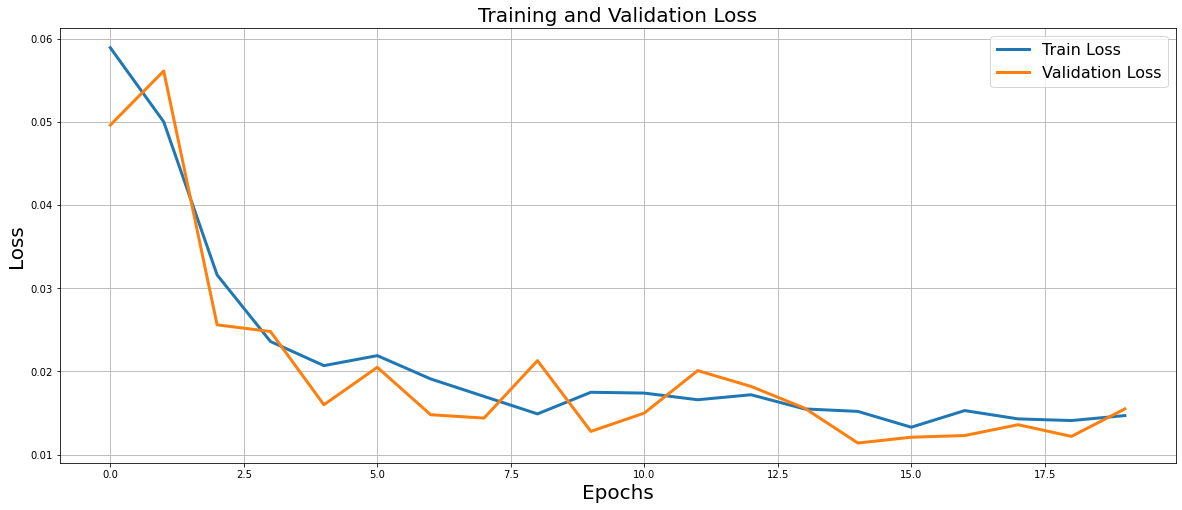

In [ ]:
# Save the training and validation loss for future visualization without
# executing the training.
results_loss = pd.DataFrame({'train_loss': loss_history['train'],
                             'val_loss': loss_history['val']})
results_loss.to_csv('results_loss.csv', sep=';', float_format='%.4f')

if os.path.exists('results_loss.csv'):
    results_loss = pd.read_csv("results_loss.csv", sep=';')

plot_loss_history(results_loss['train_loss'], results_loss['val_loss'])

In [16]:
# Prediction on Test Data
# load best saved model from the current run
# best_model = RUL_Estimator(n_features=32,
#                            hidden_dim=100, dropout=0.5,
#                            seq_length=sequence_length,
#                            num_layers=3, output_dim=1)

# if os.path.exists('models/LSTM_v0.pth'):
#     best_model.load_state_dict(torch.load('models/LSTM_v0.pth'))
#     best_model.to(device)
#     print('Loaded LSTM_v0 model.')

In [14]:
# load the scaler
target_scaler = load(open('data/N-CMAPSS/target_scaler_DS03.pkl', 'rb'))
best_model = lstm_model
RMSE = []
with torch.no_grad():
    for test_data, test_labels in dataloaders['test']:
        test_labels = target_scaler.inverse_transform(test_labels)
        test_data = test_data.to(device)
        pred = best_model(test_data)
        pred = target_scaler.inverse_transform(pred.cpu())
        RMSE.append(mean_squared_error(test_labels, pred, squared=False))
    print(f'Test RMSE: {np.mean(RMSE)}')

Test RMSE: 8.671842050582605
